# Notebook I - Climate Regime

In [ ]:
# for testing purposes
# import psutil
# # psutil.virtual_memory()
# psutil.virtual_memory().free/1E9

In [1]:
'''import supporting libraries'''
import numpy as np
import matplotlib.pyplot as plt
import os
try:
    from osgeo import gdal
except:
    import gdal    
import sys
from time import time as timer
import xarray as xr
import rioxarray as rio

gdal.UseExceptions()


In [4]:
# These paths must be modified by each user to point to the appropriate data files and directories

# branch version tag
revname='v21pv'

# # Kerrie desktop
# dir_toplev=r'C://Users/kerrie.WIN/Documents/data/'
# work_dir = r'K:/projects/unfao/pyaez_gaez/repos/PyAEZ_kerrie/PyAEZ/pyaez2.1/pyaez2.1_parvec/' # path to your PyAEZ repo
# out_path = work_dir+'NB1outputs/' # path for saving output data
# china
# data_dir = r'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_china_03272023/npy/' # path to your data
# maskfile = r'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_china_03272023/tif/mask.tif'# subset for no antarctica, 1800 lats
# elevfile = r'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_china_03272023/tif/elev.tif'
# soilfile = r'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_china_03272023/tif/soil_terrain_lulc_china_08333.tif'
# global
# data_dir = r'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_global_NOTPRODUCTION/npy/' # path to your data
# maskfile = r'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_global_NOTPRODUCTION/tif/mask_2268708_5m.tif'# subset for no antarctica, 1800 lats
# elevfile = r'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_global_NOTPRODUCTION/tif/Elevation_2268708_5m.tif'
# soilfile = r'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_global_NOTPRODUCTION/tif/soil_terrain_lulc_global_08333_clipped.tif'


# # Kerrie laptop
work_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/PyAEZ/pyaez2.1/pyaez2.1_parvec/' # path to your PyAEZ repo
out_path = work_dir+'NB1outputs/' # path for saving output data
dir_toplev=r'C://Users/kerrie/Documents/01_LocalCode/'
# china
data_dir = r'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/china/npy/' # path to your data
maskfile = r'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/china/tif/mask.tif'# subset for no antarctica, 1800 lats
elevfile = r'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/china/tif/elev.tif'
soilfile = r'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_china_03272023/tif/soil_terrain_lulc_china_08333.tif'
# specific size test domain
# data_dir = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/15GB/' # path to your data
# maskfile = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/15GB/mask.tif'# subset for no antarctica, 1800 lats
# elevfile = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/15GB/elev.tif'
# soilfile = I didn't create soil files for this
# global
# data_dir = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/global_NOTPRODUCTION/npy/' # path to your data
# maskfile = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/global_NOTPRODUCTION/tif/mask_2268708_5m.tif'# subset for no antarctica, 1800 lats
# elevfile = 'C://Users/kerrie/Documents/02_LocalData/pyAEZ_input_data/global_NOTPRODUCTION/tif/Elevation_2268708_5m.tif'
# soilfile = r'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_global_NOTPRODUCTION/tif/soil_terrain_lulc_global_08333_clipped.tif'

# Check whether the specified path exists or not
isExist = os.path.exists(out_path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(out_path)
   print("The new directory is created!")

daskpath=os.path.join(dir_toplev, "dask-worker-space-can-be-deleted")

isExist = os.path.exists(daskpath)
if not isExist:
   os.mkdir(daskpath)
   print("dask worker directory created")

In [5]:
sys.path.append(work_dir)

import ClimateRegime as ClimateRegime
clim_reg = ClimateRegime.ClimateRegime()

import UtilitiesCalc as UtilitiesCalc
obj_utilities=UtilitiesCalc.UtilitiesCalc()


In [9]:
# expect <1s run time

# DATA INFORMATION
daily = True          # Type of climate data. True: daily, False: monthly
parallel=True #False# # flag for dask parallel processing (for speed). True: use dask. False: no dask, only numpy
mask_value = 0        # pixel value in admin_mask to exclude from the analysis

if parallel:
    import dask.array as da
    import dask

start=timer()

# If parallel=True, load the inputs as lazy dask arrays, data type float32 
max_temp = da.from_npy_stack(data_dir+'Tmax-2m365/').astype('float32')  # maximum temperature
min_temp = da.from_npy_stack(data_dir+'Tmin-2m365/').astype('float32')  # minimum temperature
precipitation = da.from_npy_stack(data_dir+'Precip365/').astype('float32')  # precipitation
rel_humidity = da.from_npy_stack(data_dir+'Rhum365/').astype('float32')  # relative humidity
wind_speed = da.from_npy_stack(data_dir+'Wind-2m365/').astype('float32') # wind speed measured at two meters
short_rad = da.from_npy_stack(data_dir+'Srad365/').astype('float32')  # shortwave radiation
mask=da.from_array(gdal.Open(maskfile).ReadAsArray())
elevation=da.from_array(gdal.Open(elevfile).ReadAsArray())
soil_terrain_lulc=da.from_array(gdal.Open(soilfile).ReadAsArray())

# # If parallel=False, comment out the above and instead load the inputs as numpy arrays, data type float32 
# max_temp = np.load(data_dir+'Tmax-2m365/0.npy').astype('float32')  # maximum temperature
# min_temp = np.load(data_dir+'Tmin-2m365/0.npy').astype('float32')  # minimum temperature
# precipitation = np.load(data_dir+'Precip365/0.npy').astype('float32')  # precipitation
# rel_humidity = np.load(data_dir+'Rhum365/0.npy').astype('float32')  # relative humidity
# wind_speed = np.load(data_dir+'Wind-2m365/0.npy').astype('float32') # wind speed measured at two meters
# short_rad = np.load(data_dir+'Srad365/0.npy').astype('float32')  # shortwave radiation
# mask=gdal.Open(maskfile).ReadAsArray()
# elevation=gdal.Open(elevfile).ReadAsArray()
# soil_terrain_lulc=gdal.Open(soilfile).ReadAsArray()

print(min_temp.shape,mask.shape,soil_terrain_lulc.shape)
print(round((max_temp.nbytes+min_temp.nbytes+precipitation.nbytes+rel_humidity.nbytes+wind_speed.nbytes+short_rad.nbytes+mask.nbytes+elevation.nbytes+soil_terrain_lulc.nbytes)/1E9,2),'GB total input data')

task_time=timer()-start
task_time

(428, 741, 365) (428, 741)
2.78 GB total input data


0.005929470062255859

In [10]:
# Define the Area-Of-Interest's geographical extents

# if lat_min/lat_max values defined below are located at pixel center --> set lat_centers to True 
# if they are located at the exterior pixel edge --> set lat_centers to False
lat_centers=True 

# provide min and max latitudes (either set manually or read from a data file)
# lat_min = 18.04167
# lat_max = 53.625
# I'm limiting precision here to avoid any misalignment of the grid cells
lats=rio.open_rasterio(maskfile)['y'].data   # get array of latitudes from maskfile
lat_min = np.trunc(lats.min()*100000)/100000 # min lat value at pixel center, limit precision to 5 decimal places
lat_max = np.trunc(lats.max()*100000)/100000 # max lat value at pixel center, limit precision 5 decimal places

### Loading the imported data into the Object Class ('*clim_reg*' Class)

In [11]:
# expect <1s run time

# For parallel=True, this sets the chunk size based on the amount of available RAM and CPU threads
# There are 2 possible user overrides: 
# 1) instead of accepting the default chunk size, the user can enter the total number of 
# chunks desired in order to increase or decrease the chunk size. However, choosing very 
# large chunks may cause the notebook to fail due to lack of available memory.
# 2) The user can indicate they want to use less RAM for the computation with reduce_mem_used=True, 
# which sets a smaller chunk size that allows the computations to proceed using less than xGB RAM

# For parallel=False, this sets all parameters associated with chunking to None

start=timer()

clim_reg.setParallel(max_temp,parallel)#,nchunks=288,reduce_mem_used=True)

task_time=timer()-start
print(clim_reg.__dict__.keys())
print(clim_reg.nchunks, clim_reg.chunk3D, clim_reg.chunksize3D_MB)
print('time:',task_time)

dict_keys(['parallel', 'chunk2D', 'chunk3D', 'chunksize3D_MB', 'nchunks'])
20 (-1, 38, -1) 23.74544
time: 0.0019507408142089844


In [12]:
# expect <1s run time

# For parallel=True, this chunks clim_reg.im_mask

start=timer()

clim_reg.setStudyAreaMask(mask, mask_value)

task_time=timer()-start
print(clim_reg.__dict__.keys())
print('time:',task_time)

dict_keys(['parallel', 'chunk2D', 'chunk3D', 'chunksize3D_MB', 'nchunks', 'im_mask', 'nodata_val', 'set_mask'])
time: 0.0019478797912597656


In [13]:
# expect <1s run time

# Added functionality includes identifying whether the lat_min lat_max given
# are located at pixel centers or exterior edges. The function now takes this 
# into account when generating a 2D latitude map.

# For parallel=True, this chunks clim_reg.latitude and clim_reg.elevation

start=timer()

clim_reg.setLocationTerrainData(lat_min, lat_max, lat_centers, elevation) #KLG

task_time=timer()-start
print(clim_reg.__dict__.keys())
print('time:',task_time)


dict_keys(['parallel', 'chunk2D', 'chunk3D', 'chunksize3D_MB', 'nchunks', 'im_mask', 'nodata_val', 'set_mask', 'elevation', 'im_height', 'im_width', 'latitude'])
time: 0.002973794937133789


In [21]:
# parallel=True; for global expect ~8-12min run time
# parallel=True; for china expect 10-25s run time
# parallel=False; for china expect x

# For parallel=True, this chunks all input variables and attaches to clim_reg as lazy dask arrays which aren't held in RAM
# It computes the following as numpy arrays saved in RAM: pet_daily, meanT_monthly_sealevel, P_by_PET_monthly, 
# meanT_monthly, totalPrec_monthly, annual_Tmean, annual_accPrec, annual_accPET
# Everything else remains a dask array to be loaded and computed later when needed.

start=timer()

clim_reg.setDailyClimateData(min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)

task_time=timer()-start
print(clim_reg.__dict__.keys())
print('time:',task_time)

dict_keys(['parallel', 'chunk2D', 'chunk3D', 'chunksize3D_MB', 'nchunks', 'im_mask', 'nodata_val', 'set_mask', 'elevation', 'im_height', 'im_width', 'latitude', 'doy_start', 'doy_end', 'set_monthly', 'meanT_daily', 'meanT_monthly_sealevel', 'P_by_PET_monthly', 'maxT_daily', 'totalPrec_daily', 'meanT_monthly', 'totalPrec_monthly', 'annual_Tmean', 'annual_accPrec', 'annual_accPET', 'lgpt0', 'lgpt5', 'lgpt10', 'pet_daily'])
time: 11.352767944335938


0.06705689430236816


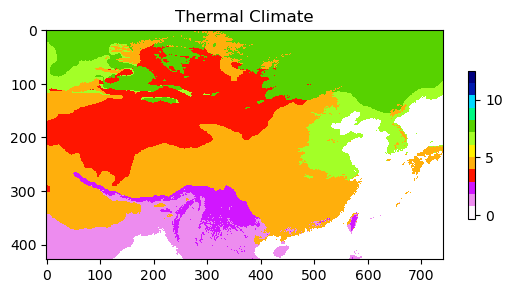

In [15]:
# parallel=True; for global expect <5s run time
# parallel=True; for china expect <1s run time

start=timer()

tclimate = clim_reg.getThermalClimate()

task_time=timer()-start
print('time:',task_time)

fig = plt.figure()
plt.imshow(tclimate, cmap=plt.get_cmap('gist_ncar_r', 12),vmin=-0.3,vmax=12.5,interpolation='none')
plt.title('Thermal Climate')
plt.colorbar(shrink=0.4)
plt.show()

0.07819533348083496


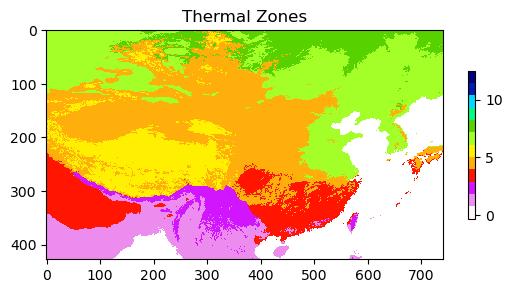

In [16]:
# parallel=True; for global expect <5s run time
# parallel=True; for china expect <1s run time

start=timer()

tzone = clim_reg.getThermalZone()

task_time=timer()-start
print('time:',task_time)

fig = plt.figure()
plt.imshow(tzone, cmap=plt.get_cmap('gist_ncar_r', 12),vmin=-0.3,vmax=12.5,interpolation='none')
plt.title('Thermal Zones')
plt.colorbar(shrink=0.4)
plt.show()

0.7194254398345947


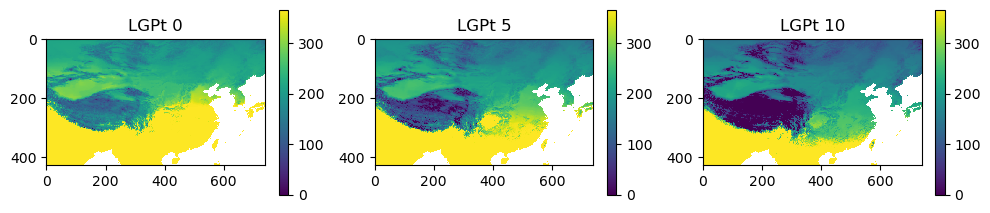

In [17]:
# parallel=True; for global expect 70-105s run time
# parallel=True; for china expect <2s run time

start=timer()

lgpt0 = clim_reg.getThermalLGP0()
lgpt5 = clim_reg.getThermalLGP5()
lgpt10 = clim_reg.getThermalLGP10()

task_time=timer()-start
print('time:',task_time)

plt.figure(figsize=(12,3))
plt.subplot(1, 3, 1)
plt.imshow(lgpt0,vmin=0,vmax=366,interpolation='none')
plt.title('LGPt 0')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 2)
plt.imshow(lgpt5, vmin=0, vmax=366,interpolation='none')
plt.title('LGPt 5')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 3)
plt.imshow(lgpt10, vmin=0, vmax=366,interpolation='none')
plt.title('LGPt 10')
plt.colorbar(shrink=0.8)
#----------------------
plt.show()

0.8323550224304199


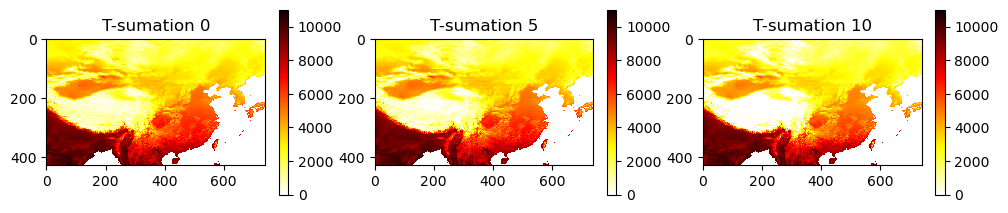

In [18]:
# parallel=True; for global expect 45-80s run time
# parallel=True; for china expect <2s run time

start=timer()

tsum0 = clim_reg.getTemperatureSum0()
tsum5 = clim_reg.getTemperatureSum5()
tsum10 = clim_reg.getTemperatureSum10()

task_time=timer()-start
print('time:',task_time)

plt.figure(figsize=(12,3))
plt.subplot(1, 3, 1)
plt.imshow(tsum0, cmap='hot_r', vmin=0, vmax=11000,interpolation='none')
plt.title('T-sumation 0')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 2)
plt.imshow(tsum5, cmap='hot_r', vmin=0, vmax=11000,interpolation='none')
plt.title('T-sumation 5')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 3)
plt.imshow(tsum10, cmap='hot_r', vmin=0, vmax=11000,interpolation='none')
plt.title('T-sumation 10')
plt.colorbar(shrink=0.8)
#----------------------
plt.show()

loop 0 of 5 , this message will print every 10 chunks
28.718610763549805


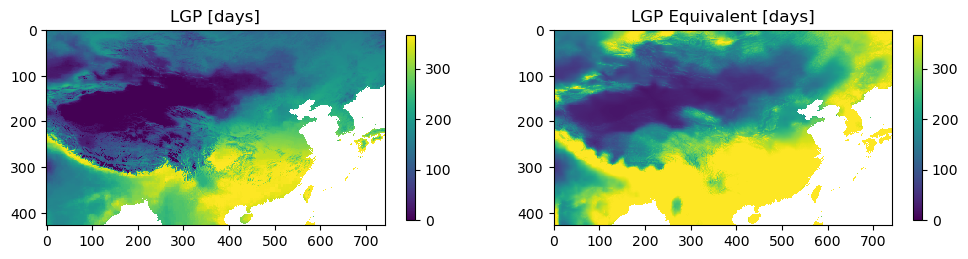

In [22]:
# parallel=True; for global expect 12-25min run time
# parallel=True; for china expect 30-50s run time

start=timer()

lgp = clim_reg.getLGP(Sa=100., D=1.)
lgp_class = clim_reg.getLGPClassified(lgp)
lgp_equv = clim_reg.getLGPEquivalent()

task_time=timer()-start
print('time:',task_time)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(lgp, cmap='viridis', vmin=0, vmax=366,interpolation='none')
plt.title('LGP [days]')
plt.colorbar(shrink=0.8)
plt.subplot(122)
plt.imshow(lgp_equv, cmap='viridis', vmin=0, vmax=366,interpolation='none')
plt.title('LGP Equivalent [days]')
plt.colorbar(shrink=0.8)
plt.show()

4.037005186080933


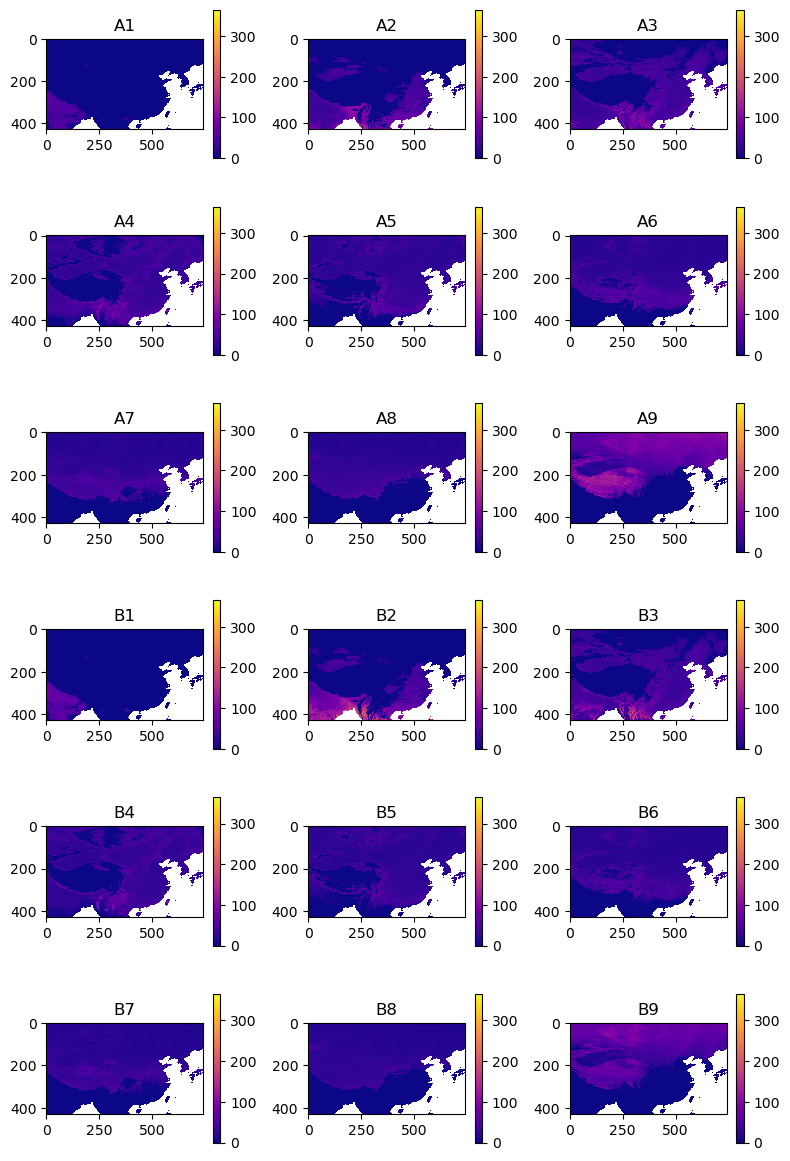

In [23]:
# parallel=True; for global expect 2.5-4min run time
# parallel=True; for china expect 5-10s run time

start=timer()

tprofile = clim_reg.getTemperatureProfile()

task_time=timer()-start
print('time:',task_time)

tile_list = ['A1','A2','A3','A4','A5','A6','A7','A8','A9',
            'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']

fig = plt.figure(figsize=(8, 12))
for i1 in range(1, 19):
    plt.subplot(6, 3, i1)
    plt.imshow(tprofile[i1-1],interpolation='none',vmin=0,vmax=365,cmap='plasma')
    plt.title(tile_list[i1-1])
    plt.colorbar(shrink=0.8)
plt.tight_layout()
plt.show()

0.466876745223999


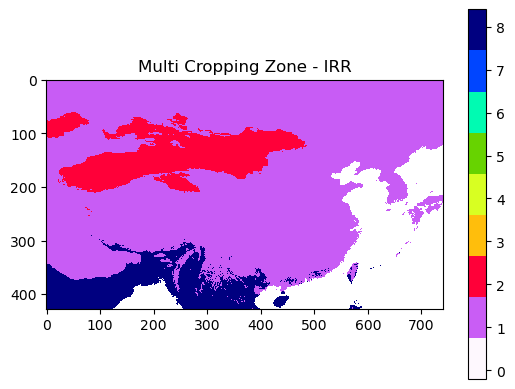

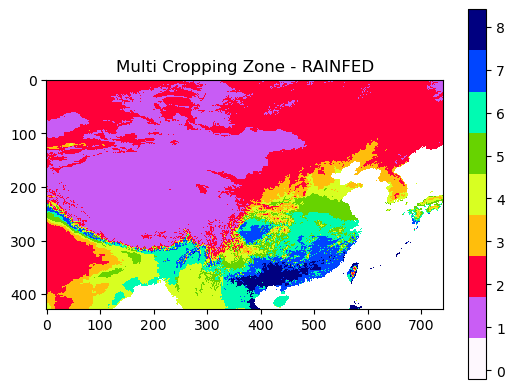

In [24]:
# parallel=True; for global expect 15-25s run time
# parallel=True; for china expect <1s run time

start=timer()

multi_crop = clim_reg.getMultiCroppingZones(tclimate, lgp, lgpt5, lgpt10, tsum0, tsum10)
multi_crop_rainfed = multi_crop[0]  # for rainfed conditions
multi_crop_irr = multi_crop[1]  # for irrigated conditions

task_time=timer()-start
print('time:',task_time)

fig = plt.figure()
plt.imshow(multi_crop_irr, cmap=plt.get_cmap('gist_ncar_r', 9), vmin=-0.2, vmax=8.4,interpolation='none')
plt.title('Multi Cropping Zone - IRR')
plt.colorbar()
plt.show()

fig = plt.figure()
plt.imshow(multi_crop_rainfed,cmap=plt.get_cmap('gist_ncar_r', 9), vmin=-0.2, vmax=8.4,interpolation='none')
plt.title('Multi Cropping Zone - RAINFED')
plt.colorbar()
plt.show()

0.7013547420501709


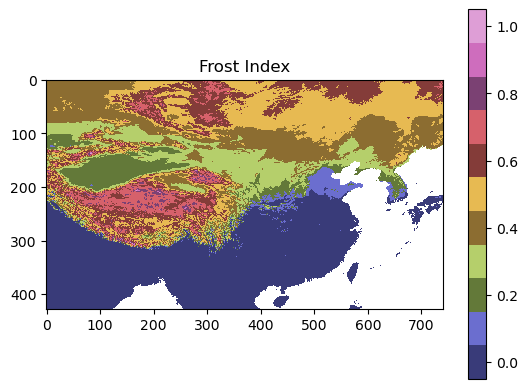

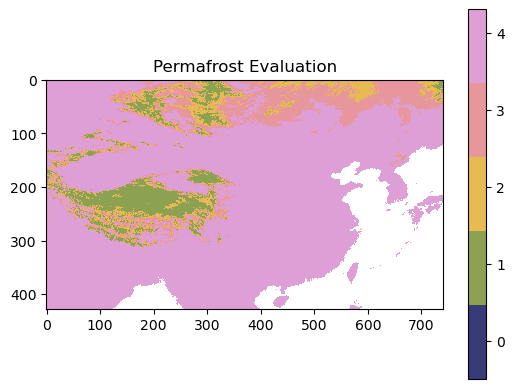

In [25]:
# parallel=True; for global expect 75-90s run time
# parallel=True; for china expect <2s run time

start=timer()

permafrost_eval = clim_reg.AirFrostIndexandPermafrostEvaluation()
frost_index = permafrost_eval[0]
permafrost = permafrost_eval[1]

task_time=timer()-start
print('time:',task_time)

fig = plt.figure()
plt.imshow(frost_index, cmap=plt.get_cmap('tab20b', 11), vmin=-0.05, vmax=1.05,interpolation='none')
plt.title('Frost Index')
plt.colorbar()
plt.show()

fig = plt.figure()
plt.imshow(permafrost, cmap=plt.get_cmap('tab20b', 5), vmin=-0.5, vmax=4.3,interpolation='none')
plt.title('Permafrost Evaluation')
plt.colorbar()
plt.show()

0.019971847534179688


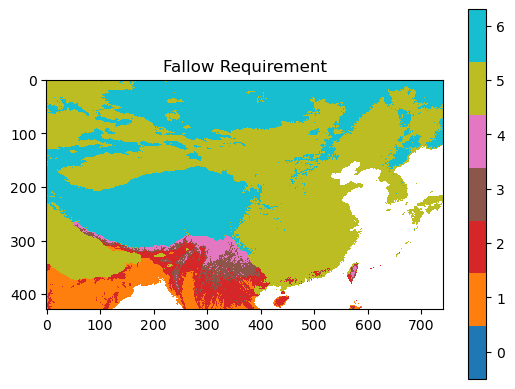

In [26]:
# parallel=True; for global expect <2s run time
# parallel=True; for china expect <1s run time

start=timer()

tzone_fallow = clim_reg.TZoneFallowRequirement(tzone)

task_time=timer()-start
print('time:',task_time)

fig = plt.figure()
plt.imshow(tzone_fallow, cmap=plt.get_cmap('tab10', 7), vmin=-0.5, vmax=6.3,interpolation='none')
plt.title('Fallow Requirement')
plt.colorbar()
plt.show()

In [19]:
# check dtypes of all outputs, we intend them all to be float32
outputs=[tclimate,tzone,lgpt0,lgpt5,lgpt10,tsum0,tsum5,tsum10,tprofile,lgp,lgp_class,lgp_equv,multi_crop_rainfed,multi_crop_irr,frost_index,permafrost,tzone_fallow]
dtypes=[]
for var in outputs:
    # for arrays
    try:
        dt=var.dtype
        dtypes.append(dt)
    # for lists of arrays
    except:
        for v in var:
            dt=v.dtype
            dtypes.append(dt)

print(dtypes)

[dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32')]


### Agro-ecological zones classification
The agro-ecological zones (AEZ) methodology provides a framework for establishing a spatial inventory of land resources compiled from global/national environmental data sets and assembled to quantify multiple spatial characteristics required for the assessments of land productivity under location-specific agro-ecological conditions.

In [23]:
# parallel=True; for global expect 50-60s run time
# parallel=True; for china expect 1s run time

# expect ~ minutes run time for global
start=timer()

aez = clim_reg.AEZClassification(tclimate, lgp, lgp_equv, lgpt5, soil_terrain_lulc, permafrost)

task_time=timer()-start
print('time:',task_time)

69.76035046577454

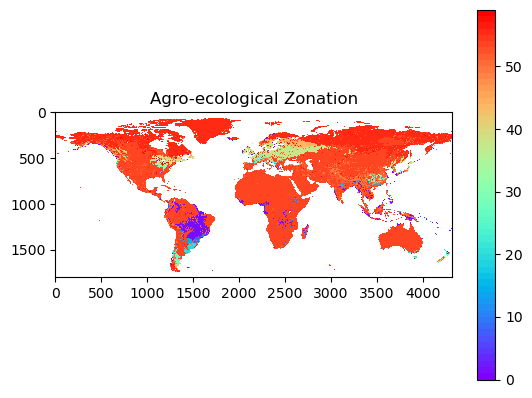

In [24]:
# now visualizing result
fig = plt.figure()
plt.imshow(aez, cmap=plt.get_cmap('rainbow', 59), vmin=0, vmax=59,interpolation='none')
plt.title('Agro-ecological Zonation')
plt.colorbar()
plt.savefig(out_path+"aez_"+revname+".png",bbox_inches="tight", dpi=600)
plt.show()

<hr>

### END OF MODULE 1: CLIMATE REGIME

<hr>